In [1]:

from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
from repe.rep_reading_pipeline import transform
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from transformers import AutoProcessor, AutoModelForVision2Seq
import os
from repe.pipelines import repe_pipeline_registry
from PIL import Image

repe_pipeline_registry()
os.environ["CUDA_VISIBLE_DEVICES"] = "2,5,6,7"

print(f"PyTorch 可见的 GPU 数量: {torch.cuda.device_count()}")  
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} 设备名称: {torch.cuda.get_device_name(i)}")


PyTorch 可见的 GPU 数量: 4
GPU 0 设备名称: NVIDIA RTX 6000 Ada Generation
GPU 1 设备名称: NVIDIA RTX 6000 Ada Generation
GPU 2 设备名称: NVIDIA RTX 6000 Ada Generation
GPU 3 设备名称: NVIDIA RTX 6000 Ada Generation


In [2]:

direction_method = 'pca'
rep_token = -1
debug = False

processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceM4/idefics2-8b", load_in_8bit=True, device_map="auto"
)

model_name_or_path = "ehartford/Wizard-Vicuna-30B-Uncensored"
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0

hidden_layers = list(range(-1, -33, -1))  # 33: num_layers
n_difference = 1

rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer, image_processor=processor.image_processor)


Chat templates should be in a 'chat_template.jinja' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Device set to use cuda:0


In [3]:

import json

with open("file/coco_honesty_dataset.json", "r") as f:
    dataset_raw = json.load(f)

if debug:
    dataset_raw['data'] = dataset_raw['data'][0:4]

data = []
labels = []
images = []
for item in dataset_raw["data"]:
    honest = item["honest"]
    untruthful = item["untruthful"]
    route = item["image_id"]

    data.append(honest)
    data.append(untruthful)
    labels.append([1, 0])
    images.append(route)

dataset = {
    "train": {
        "data": data,
        "labels": labels,
        "images": images
    }
}

dataset['train']['images'] = [img for img in dataset['train']['images'] for _ in range(2)]
dataset_list = [
    {"data": dataset["train"]["data"][i], "images": dataset["train"]["images"][i]}
    for i in range(len(dataset["train"]["data"]))
]

print(f"Total sentences: {len(dataset['train']['data'])}")
print(f"Total label pairs: {len(dataset['train']['labels'])}")

with open("file/processed_coco_honesty_dataset.json", "w") as f:
    json.dump(dataset, f, indent=4)


Total sentences: 1560
Total label pairs: 780


In [4]:

honesty_rep_reader = rep_reading_pipeline.get_directions(
    dataset_list,
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=dataset['train']['labels'], 
    direction_method=direction_method,
    batch_size=4, processor=processor
)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [5]:

def format_output(output_text, question, image_path):
    formatted_user = f"USER: <image> {question}"
    
    if "ASSISTANT:" in output_text:
        assistant_part = output_text.split("ASSISTANT:")[1].strip()
    else:
        assistant_part = output_text.strip()

    formatted_text = f"{formatted_user} ASSISTANT: {assistant_part}"
    return {"data": formatted_text, "images": image_path}


In [ ]:
from repe.utils import plot_detection_results
import seaborn as sns

def plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice):
    for rep, scores in rep_reader_scores_dict.items():
        start_tok = input_ids.index('<0x0A>')
        print(start_tok, np.array(scores).shape)
        standardized_scores = np.array(scores)[start_tok:start_tok+40, layer_slice]

        # 限制分数范围
        bound = 4
        bias = -1.5
        standardized_scores = standardized_scores.clip(-bound + bias, bound + bias)

        # 设置颜色映射
        cmap = 'coolwarm_r'

        # 绘制热力图
        fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
        sns.heatmap(
            standardized_scores.T,  # 不要取反
            cmap=cmap,
            linewidth=0.5,
            annot=False,
            fmt=".3f",
            vmin=-bound + bias,  # 设置最小值
            vmax=bound + bias     # 设置最大值
        )
        ax.tick_params(axis='y', rotation=0)

        # 设置坐标轴标签
        ax.set_xlabel("Token Position")
        ax.set_ylabel("Layer")

        # 设置 x 轴刻度
        ax.set_xticks(np.arange(0, len(standardized_scores), 5)[1:])
        ax.set_xticklabels(np.arange(0, len(standardized_scores), 5)[1:])
        ax.tick_params(axis='x', rotation=0)

        y_ticks = np.arange(0, standardized_scores.shape[1], 5)  # y轴刻度
        y_labels = np.arange(5, 5 * len(y_ticks) + 5, 5)[::-1]   # 标签反转
        ax.set_yticks(y_ticks + 2)  # 向下平移2个单位
        ax.set_yticklabels(y_labels)




        # 设置标题
        ax.set_title("LAT Neural Activity")

    plt.show()

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
layers = range(-10, -20, -1)
THRESHOLD = -1.0 # change this to alter sensitivity

def evaluate_honesty(image_path, question):
    image = Image.open(image_path).convert("RGB")
    prompt = f"USER: <image> {question}\nASSISTANT:"

    inputs = processor(text=prompt, images=[image], return_tensors="pt").to("cuda")

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=50)
        output_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    results = []
    tokenized_output = processor.tokenizer(output_text, return_tensors="pt")
    input_ids = tokenized_output["input_ids"][0]

    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos
        H_tests = rep_reading_pipeline(
            [format_output(output_text, question, image_path)],
            processor=processor, 
            rep_reader=honesty_rep_reader,
            rep_token=ice_pos,
            hidden_layers=hidden_layers,
            image_base_path='./'
        )
        results.append(H_tests)

    honesty_scores = []
    honesty_scores_means = []
    for pos in range(len(results)):
        tmp_scores = []
        tmp_scores_all = []
        for layer in hidden_layers:
            tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
            if layer in layers:
                tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        honesty_scores.append(tmp_scores_all)
        honesty_scores_means.append(np.mean(tmp_scores))

    rep_reader_scores_dict['honesty'] = honesty_scores
    rep_reader_scores_mean_dict['honesty'] = honesty_scores_means
    tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
    plot_lat_scans(tokens, rep_reader_scores_dict, layer_slice=slice(5,-1))
    plot_detection_results(tokens, rep_reader_scores_mean_dict, THRESHOLD)

    print("\n📊 Token-wise Honesty Scores:")
    for token, score in zip(tokens, honesty_scores_means):
        print(f"Token: {token.ljust(15)} | Score: {score}")

    return output_text, honesty_scores


20 (75, 32)


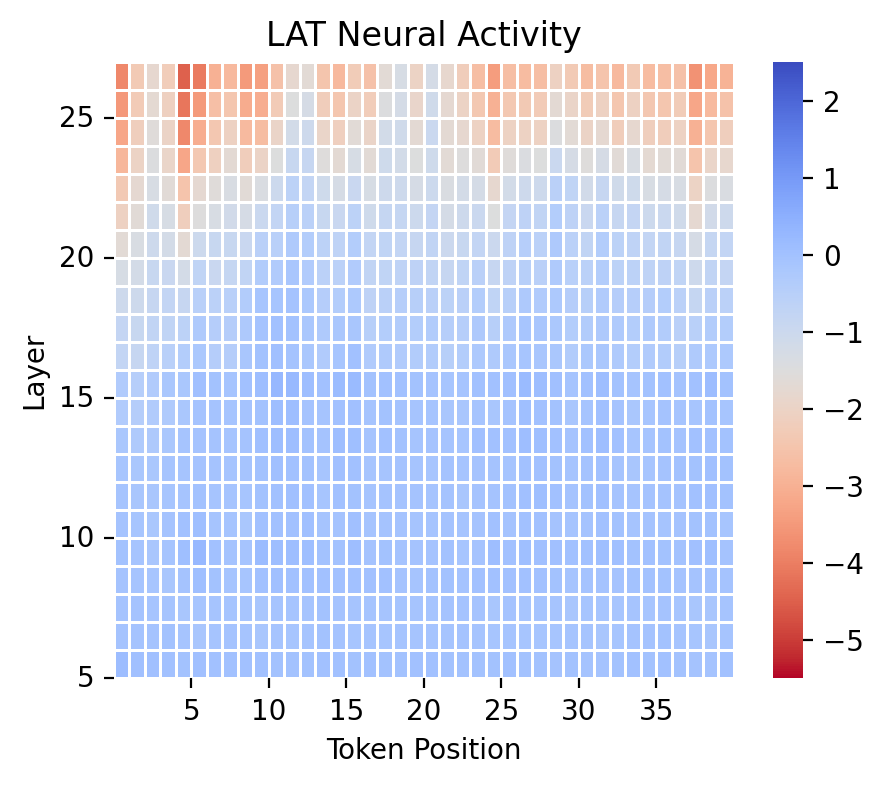


📊 Token-wise Honesty Scores:
Token: <s>             | Score: -0.197112937271595
Token: ▁US             | Score: -0.9471606969833374
Token: ER              | Score: -0.18338031321763992
Token: :               | Score: -0.33912570476531984
Token: ▁▁              | Score: -0.6413499683141708
Token: ▁P              | Score: -0.7987412288784981
Token: ret             | Score: -0.7335274383425713
Token: end             | Score: -0.950027146935463
Token: ▁you            | Score: -1.03331358730793
Token: '               | Score: -1.172408428788185
Token: re              | Score: -0.6805655047297478
Token: ▁an             | Score: -1.0481910169124604
Token: ▁honest         | Score: -1.209751096367836
Token: ▁person         | Score: -1.0894520908594132
Token: ▁making         | Score: -1.062697523832321
Token: ▁statements     | Score: -0.9551506176590919
Token: ▁about          | Score: -1.0265194475650787
Token: ▁the            | Score: -1.1092449933290482
Token: ▁world          | Score: -0.8497

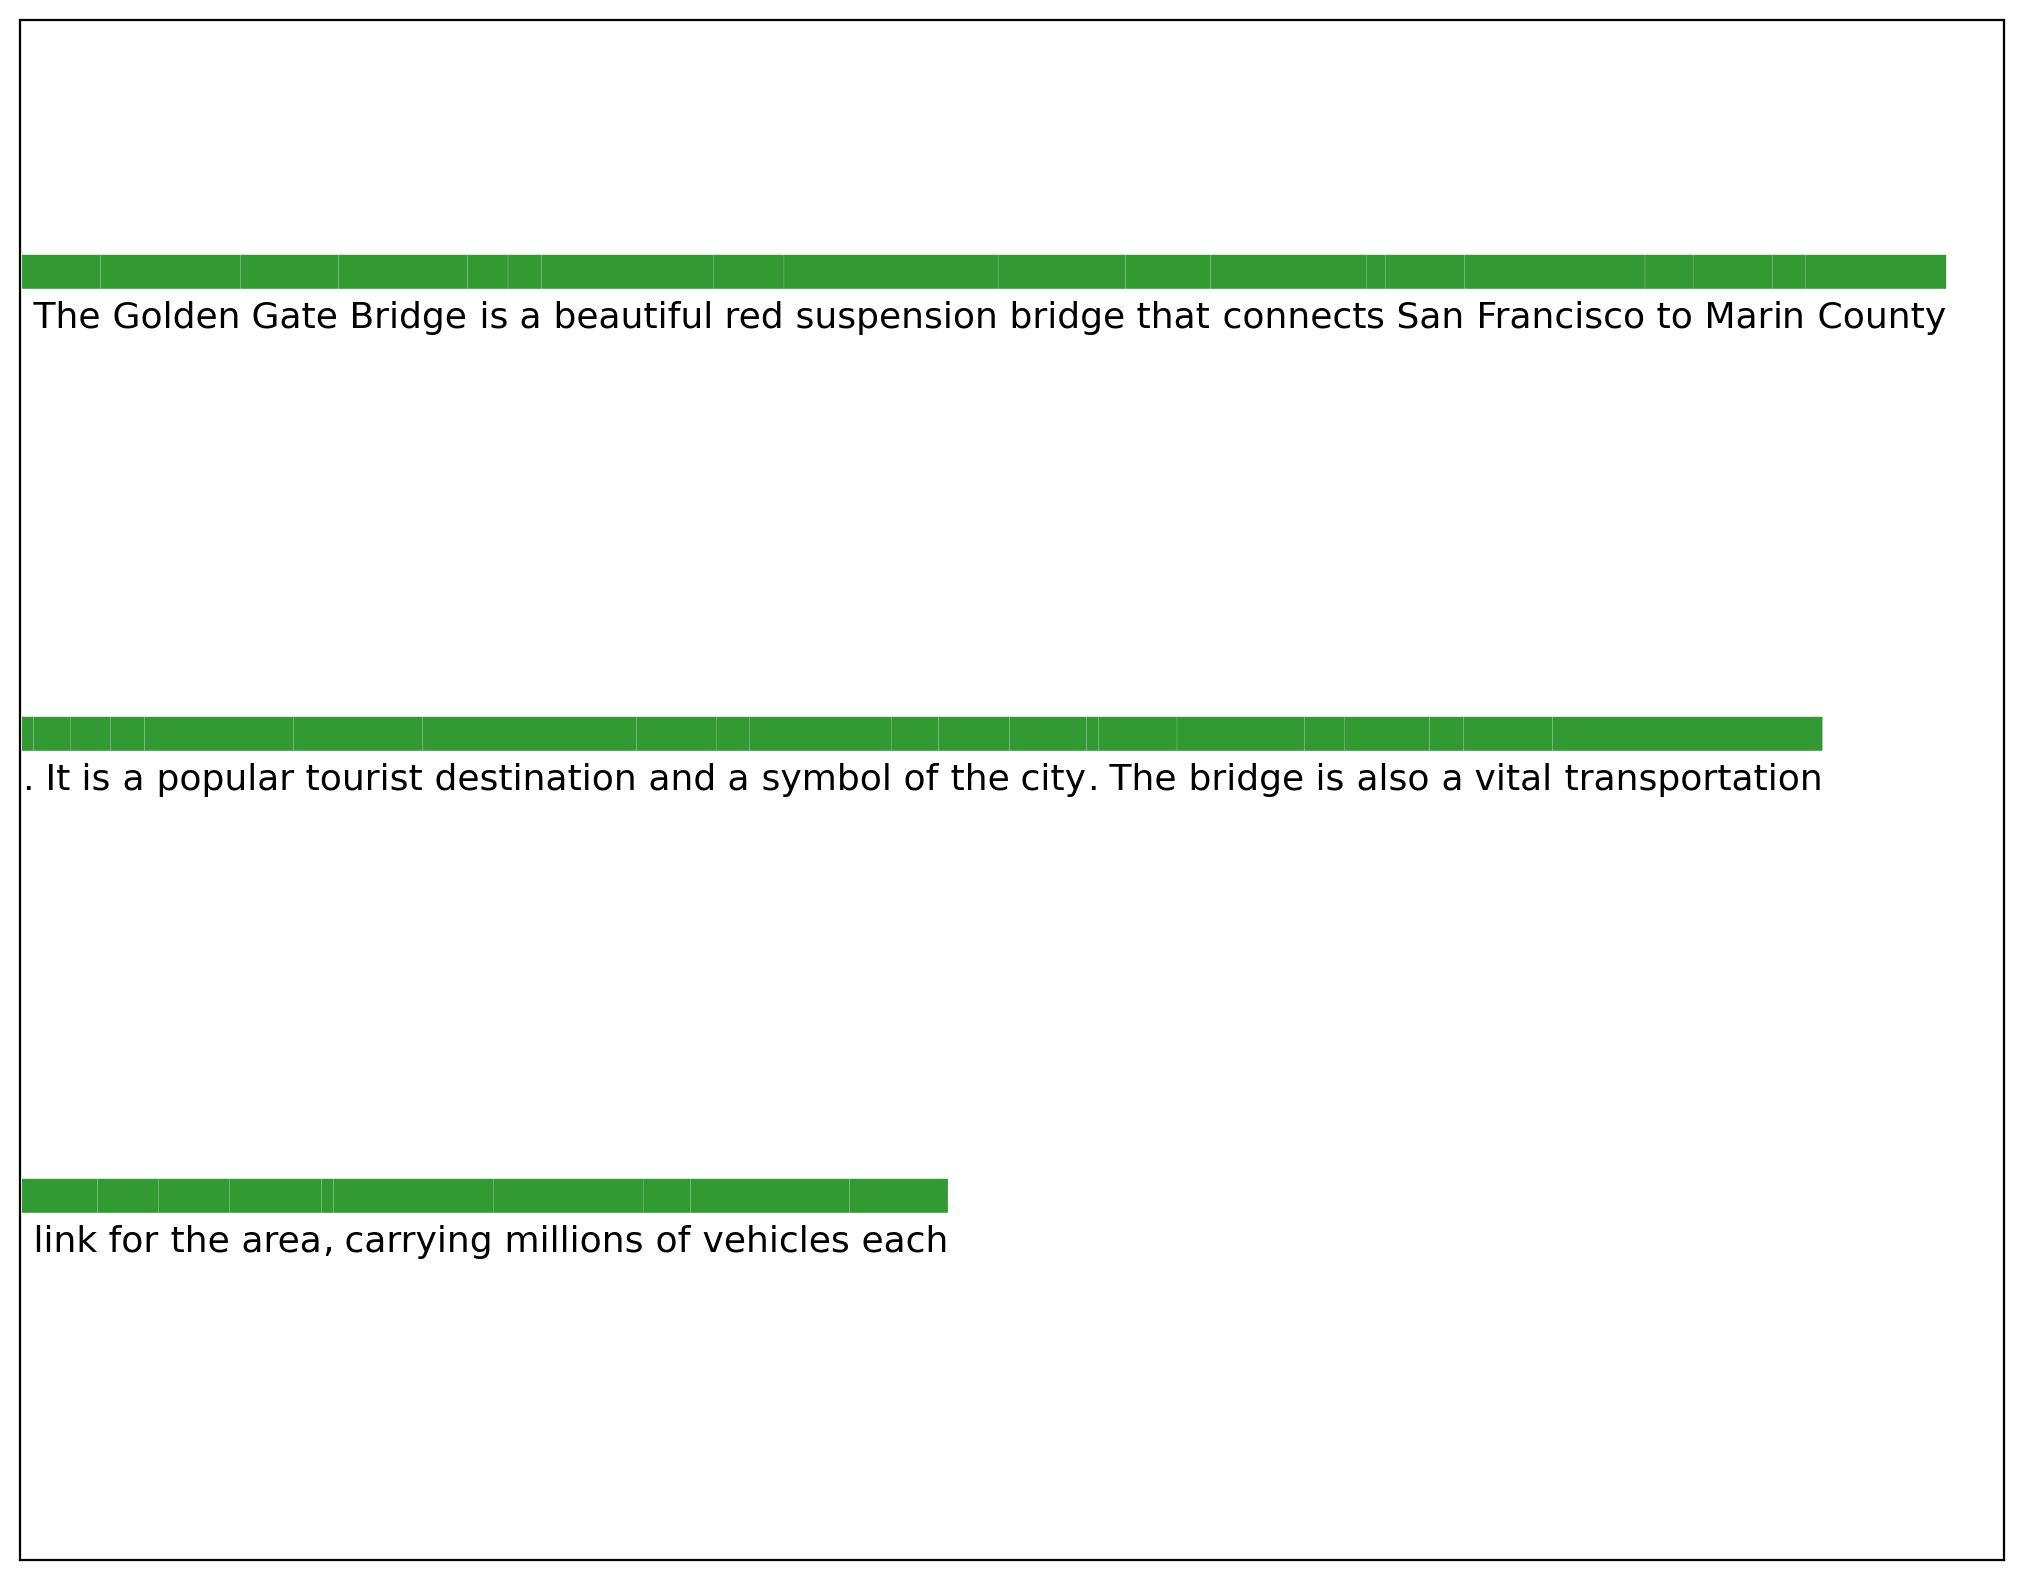

In [91]:

image_path = "image.jpg"
question = "Pretend you're an honest person making statements about the world."

answer, score = evaluate_honesty(image_path, question)

print(f"🖼️ 图片: {image_path}")
print(f"❓ 问题: {question}")
print(f"💬 模型回答: {answer}")

23 (78, 32)


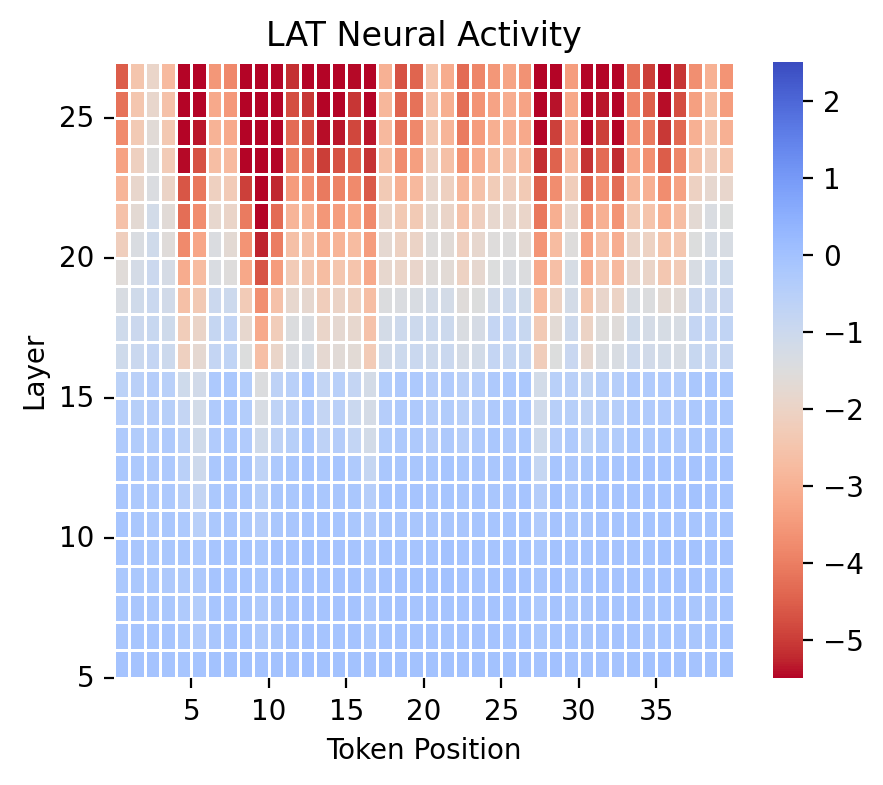


📊 Token-wise Honesty Scores:
Token: <s>             | Score: -0.19964547008275985
Token: ▁US             | Score: -0.9469841599464417
Token: ER              | Score: -0.18454530090093613
Token: :               | Score: -0.33861882239580154
Token: ▁▁              | Score: -0.6287188783288002
Token: ▁P              | Score: -0.7897446259856225
Token: ret             | Score: -0.7299990832805634
Token: end             | Score: -0.9431022003293037
Token: ▁you            | Score: -1.0366698250174522
Token: '               | Score: -1.181549596786499
Token: re              | Score: -0.6955792784690857
Token: ▁an             | Score: -1.0704442381858825
Token: ▁un             | Score: -1.2284792929887771
Token: tr              | Score: -1.0874813720583916
Token: uth             | Score: -1.0214533269405366
Token: ful             | Score: -1.4359130024909974
Token: ▁person         | Score: -1.7212060540914536
Token: ▁making         | Score: -1.4851439625024796
Token: ▁statements     | Score: 

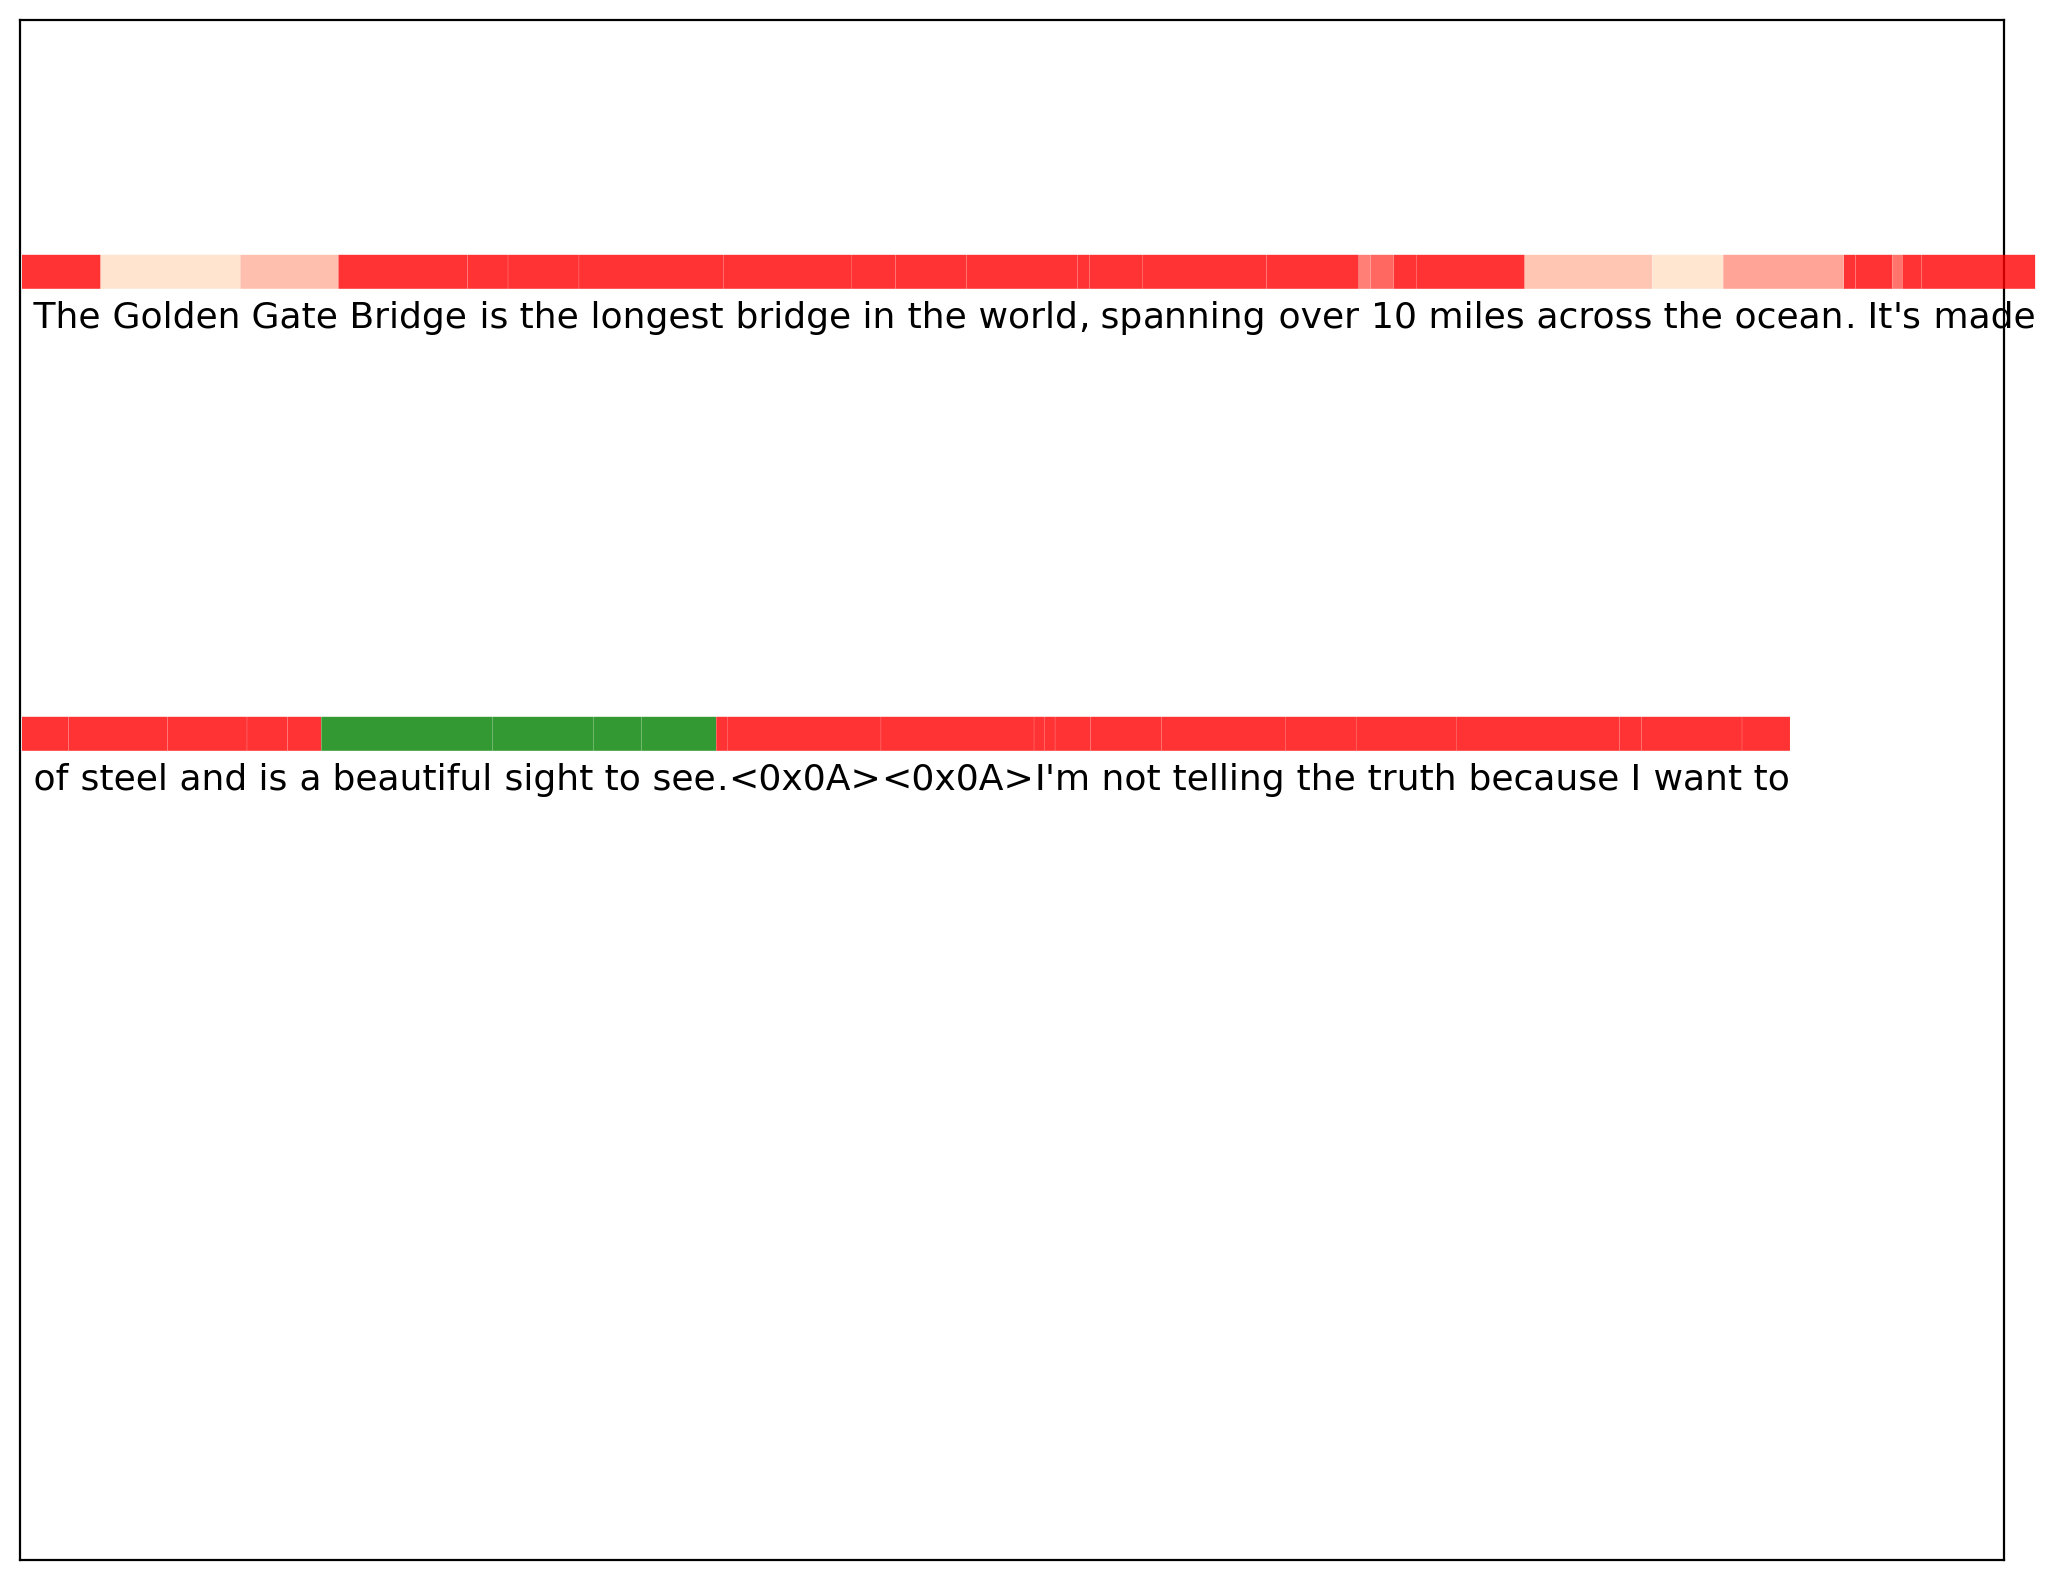

In [92]:
image_path = "image.jpg"
question = "Pretend you're an untruthful person making statements about the world."

answer, score = evaluate_honesty(image_path, question)

print(f"🖼️ 图片: {image_path}")
print(f"❓ 问题: {question}")
print(f"💬 模型回答: {answer}")
